In [2]:
import numpy as np
import pandas as pd
import time

In [165]:
intraday_price = [36.5,51.1,79.7,38.1,62.34,99]

In [211]:
def DM_high(frequency):
    if frequency<50.015:
        return 0
    elif frequency<50.1:
        return ((frequency-50.015)/0.085)*0.05
    elif frequency<50.2:
        return 0.05+((frequency-50.1)/0.1)*0.95
    else:
        return 1
    
def DM_low(frequency):
    if frequency>49.985:
        return 0
    elif (frequency>49.9):
        return ((-frequency+49.985)/0.085)*0.05
    elif frequency>49.8:
        return 0.05+((49.9-frequency)/0.1)*0.95
    else:
        return 1
    
def DC_high(frequency):
    if frequency<50.015:
        return 0
    elif frequency<50.2:
        return ((frequency-50.015)/0.185)*0.05
    elif frequency<50.5:
        return 0.05+((frequency-50.2)/0.3)*0.95
    else:
        return 1
    
def DC_low(frequency):
    if frequency>49.985:
        return 0
    elif (frequency>49.8):
        return ((-frequency+49.985)/0.185)*0.05
    elif frequency>49.5:
        return 0.05+((49.8-frequency)/0.3)*0.95
    else:
        return 1

def financial_value(time, usage, price):
    bidding_period = ((time.hour%23)+1)//4
    #multiply the usage for each MW by 4 to account for the 4-hour length of the period and multiply with the prices for a MWh
    #in that corresponding bidding window
    return usage*price[bidding_period]*4


In [149]:
#predict revenue from energy sales

#transform frequency data into EAC response data split between the three services

#load data
data = pd.read_csv('Data/Frequency/fnew-2024-4.csv')
data['dtm'] = pd.to_datetime(data['dtm'])
condition_high = (data['f'] >= 50.015)
condition_low = (data['f'] <= 49.985)

data['DR High %'] = np.minimum(1,condition_high * (data['f']-50.015)/0.1985)
data['DR Low %'] = np.minimum(1,condition_low * (50.015-data['f'])/0.1985)

data['DM High %'] = data['f'].apply(DM_high)
data['DM Low %'] = data['f'].apply(DM_low)

data['DC High %'] = data['f'].apply(DC_high)
data['DC Low %'] = data['f'].apply(DC_low)



In [134]:
data.head()

,dtm,f,DR High %,DR Low %,DM High %,DM Low %,DC High %,DC Low %
0,2024-04-01 00:00:00,50.099,0.423174,-0.0,0.049412,0.0,0.022703,0.0
1,2024-04-01 00:00:01,50.089,0.372796,-0.0,0.043529,0.0,0.020000,0.0
2,2024-04-01 00:00:02,50.074,0.297229,-0.0,0.034706,0.0,0.015946,0.0
3,2024-04-01 00:00:03,50.062,0.236776,-0.0,0.027647,0.0,0.012703,0.0
4,2024-04-01 00:00:04,50.054,0.196474,-0.0,0.022941,0.0,0.010541,0.0


In [120]:
#extract all rows from april 23rd
# Define the date you want to filter by
specific_date = '2024-04-03'

# Filter the DataFrame for the specific date
filtered_df = data[data['dtm'].dt.date == pd.to_datetime(specific_date).date()]

In [121]:
filtered_df.head()

,dtm,f,DR High %,DR Low %,DM High %,DM Low %,DC High %,DC Low %
172800,2024-04-03 00:00:00,50.133,0.594458,-0.0,0.363500,0.0,0.031892,0.0
172801,2024-04-03 00:00:01,50.121,0.534005,-0.0,0.249500,0.0,0.028649,0.0
172802,2024-04-03 00:00:02,50.110,0.478589,-0.0,0.145000,0.0,0.025676,0.0
172803,2024-04-03 00:00:03,50.099,0.423174,-0.0,0.049412,0.0,0.022703,0.0
172804,2024-04-03 00:00:04,50.095,0.403023,-0.0,0.047059,0.0,0.021622,0.0


In [163]:
#resample the data into 4-hour windows with an offset of 3 hours
df_EAC_windows = data.resample('4h', on='dtm', offset='3h').mean()

In [230]:
# Create a DataFrame with the same index and the 'f' column copied directly
df_financial = df_EAC_windows[['f']].copy()

# Apply financial_value to each element of the DataFrame and assign to new columns
df_financial = df_financial.join(
    df_EAC_windows.iloc[:, 1:].apply(lambda col: col.index.to_series().map(lambda idx: financial_value(idx, col[idx], intraday_price)))
)

In [231]:
df_financial.head()

,f,DR High %,DR Low %,DM High %,DM Low %,DC High %,DC Low %
dtm,,,,,,,
2024-03-31 23:00:00,49.989301,15.120855,33.189359,1.881839,6.599557,0.811213,1.185713
2024-04-01 03:00:00,50.015113,30.202560,29.086598,9.643498,3.043768,1.631591,0.937244
2024-04-01 07:00:00,49.971430,21.041425,89.197918,3.319674,21.285193,1.128844,3.295621
2024-04-01 11:00:00,50.002526,17.738093,26.661736,3.262397,4.051455,0.951625,0.921165
2024-04-01 15:00:00,49.960562,19.586677,87.136420,5.027792,22.325623,1.050799,3.312458


In [229]:
df_financial.head()

,f,DR High %,DR Low %,DM High %,DM Low %,DC High %,DC Low %
dtm,,,,,,,
2024-03-31 23:00:00,49.989301,15.120855,33.189359,1.881839,6.599557,0.811213,1.185713
2024-04-01 03:00:00,50.015113,30.202560,29.086598,9.643498,3.043768,1.631591,0.937244
2024-04-01 07:00:00,49.971430,21.041425,89.197918,3.319674,21.285193,1.128844,3.295621
2024-04-01 11:00:00,50.002526,17.738093,26.661736,3.262397,4.051455,0.951625,0.921165
2024-04-01 15:00:00,49.960562,19.586677,87.136420,5.027792,22.325623,1.050799,3.312458


<Axes: >

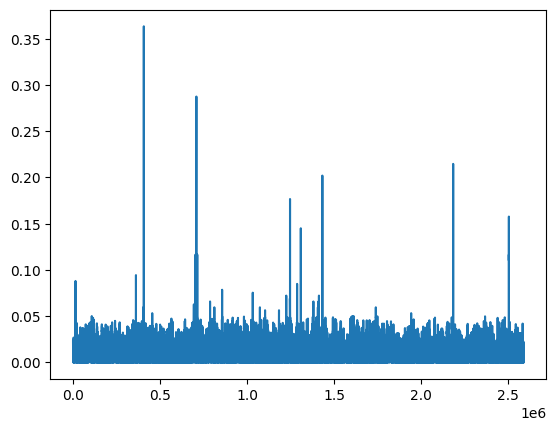

In [112]:
data['DC High %'].plot()